# Pipeline Julien - Riemann projection (cov, ts, ss, estimator)

## Introduction
This notebook is a part of the project to compare the performance of different pipelines for EEG elbow movement classification. The goal of these notebooks is to establish a standard pipeline for EEG elbow movement classification. 

This notebook explores the performance of the riemann pipeline. The riemann pipeline is a standard pipeline for EEG classification. It is based on the riemannian geometry of covariance matrices. The pipeline is composed of 3 main steps:
1. Feature extraction: Covariance matrices, tangent space projection, standard scaler
2. Classification: Logistic regression, Linear discriminant analysis, Support vector machine, Random forest
3. Evaluation: Balanced accuracy

We also establised 4 tests to evaluate the performance of the pipeline in cross-validation:
-  Tester A: Seen session / seen subject (but not the same data)
-  Tester B: Unseen session / seen subject (but not the same data)
-  Tester C: Unseen session / unseen subject
-  Tester X: All epochs shuffled

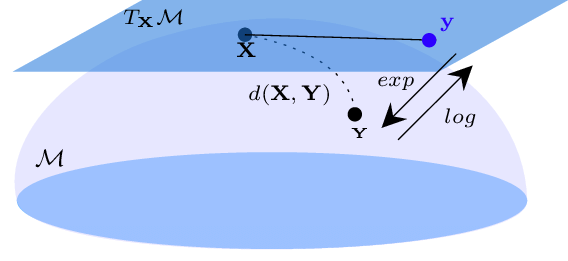

## Methodology
In this notebook we aim to establish the performance of the rieman pipeline. Here are the steps we will follow:
1. Preprocessing:
    - Loading the data from each .npy file using Dataloader built for this project.
    - Using only the session which record the movement of the arm oposite to stroke side. (REQUIREMENT)
    - Using only the electrodes from the stroke side. (REQUIREMENT)
    - Labeling the data using the acceleration (done in the dataloader, see ./notebooks/exploration_data/Labelling_data.ipynb for the exact process)
    - Filtering the data between 1 and 40 Hz.
    - Getting the train and test data by epoching around the movement onset. 1=extension 2=flexion 0=rest(or no onset to be precise) To get data labelled 0 we took epoch from 4s to 1s before movement onset.
    - Relabelling extension and flexion as 1 and no onset as 0.
2. Feature extraction:
    -  Covariances matrices :\
    The first step involves computing the covariance matrix of EEG signals. Covariance measures how two variables change together. For EEG signals, this helps in understanding how different sensors (or channels) record signals that are correlated with each other. This is crucial for capturing spatial relationships among different EEG channels. Essentially, it's about finding patterns in how different parts of the brain signal together during different movements.
    -  Tangent space features :\
     After computing the covariance matrices, they are often projected into a tangent space. The tangent space is a linear space that 'touches' a nonlinear surface (in this case, the space of covariance matrices) at a point. This linearization of covariance data, which can naturally be nonlinear and reside on a manifold (a curved surface in a higher-dimensional space), makes it easier to apply standard machine learning techniques, which generally perform better with linear data. Think of this step as a way to simplify and flatten complex, curved data into a more understandable and processable form.
    -  Standard scaler :\
    Ensures that all features are equally weighted.
3. Classification: (compared differents classifiers)
    -  Logistic regression
    -  Linear discriminant analysis
    -  Support vector machine
    -  Random forest
4. Evaluation:
    1. Evaluation on epoched data. Using balanced accuracy to evaluate the performance of the pipeline using 3 differents testers:
        -  Tester 1: Seen session / seen subject (but not the same data)
        -  Tester 2: Unseen session / seen subject (but not the same data)
        -  Tester 3: Unseen session / unseen subject
    2. Evaluation on continuous data. Using balanced accuracy to evaluate the performance of the pipeline using 3 differents testers:
        -  Tester 1: Seen session / seen subject (but not the same data)
        -  Tester 2: Unseen session / seen subject (but not the same data)
        -  Tester 3: Unseen session / unseen subject

In [1]:
from preprocessing import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import mne
import os

## Hyperparameters

In [2]:
NUMBER_OF_SESSIONS = 30

# Fréquence de filtrage
FMIN = 1
FMAX = 40

# Bornes époques
EPOCHS_TMIN = -1
EPOCHS_TMAX = 2

# temps depuis le mouvement pour époquer autours d'une plage sans mouvement
EPOCHS_EMPTY_FROM_MVT_TMINS = -4

BINARY_CLASSIFICATION = True

RANDOM_STATE = 42
N_SPLIT = 4

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

## Preprocessing

In [3]:
def get_channels(raws, side):
    endings = ('1', '3', '5', '7', '9') if side=='D' else ('2', '4', '6', '8', '10')
    channels_to_remove = [channel for channel in raws.ch_names if channel.endswith(endings)]
    channels = [channel for channel in raws.ch_names if channel not in channels_to_remove]
    return channels

In [4]:
import tqdm

def preproc(file_path_list, verbose=False):
    # structure data_patients = [session1, session2, ...]            dtype = list
    # structure data_session  = [epoch1, epoch2, ...]                dtype = np.array
    # structure epoch         = np.array([channel1, channel2, ...])  dtype = np.array
    # structure channel       = np.array([time1, time2, ...])        dtype = float

    # structure labels_patients     = [session1, session2, ...]            dtype = list
    # structure labels_session      = [label_epoch1, label_epoch2, ...]    dtype = int (0, 1, 2)

    data_patients = []
    labels_patients = []

    patients_id = []
    sessions_id = []

    for file in tqdm.tqdm(file_path_list):

        # loading data / auto labeling behind the scene
        data_loader = DataLoader(file)

        # picking the arm session opposite to the stroke side
        stroke = data_loader.stroke_side
        arm_side = 'G' if stroke == 'D' else 'G'
        raws = data_loader.get_raws(side=arm_side)
        
        # if no data for the arm side, we skip the session
        if raws is None:
            continue

        # picking channels of only the stroke side
        raws.pick_channels(get_channels(raws, stroke))

        # filtering
        raws.filter(FMIN, FMAX, fir_design='firwin')

        # creating epochs over flexion and extension of the arm (movement)
        events = mne.find_events(raws, stim_channel=['movement'])
        picks = mne.pick_types(raws.info, eeg=True, stim=False)
        epochs = mne.Epochs(raws, events, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)
        epochs_data_mvt = epochs.get_data()
        label_mvt = epochs.events[:, -1]

        # creating artificial epoch when no movement
        epochs_no_mvt = mne.Epochs(raws, events, tmin=EPOCHS_EMPTY_FROM_MVT_TMINS, tmax=EPOCHS_EMPTY_FROM_MVT_TMINS+EPOCHS_TMAX-EPOCHS_TMIN, 
                                    picks=picks, baseline=None, preload=True)
        epochs_data_no_mvt = epochs_no_mvt.get_data()
        labels_no_mvt = np.zeros(epochs_data_no_mvt.shape[0])

        # concatenating epochs
        epochs_data_session = np.concatenate((epochs_data_mvt, epochs_data_no_mvt), axis=0)
        labels_session = np.concatenate((label_mvt, labels_no_mvt), axis=0)

        # Shuffling epochs
        random_state = np.random.RandomState(RANDOM_STATE)
        indices = np.arange(epochs_data_session.shape[0])
        random_state.shuffle(indices)
        epochs_data_session = epochs_data_session[indices]
        labels_session = labels_session[indices]

        # if binary classification, we merge flexion and extension
        if BINARY_CLASSIFICATION:
            labels_session[labels_session != 0] = 1

        # adding session data and session labels to data_patients and labels_patients (if new patient, add new list)
        if data_loader.patient_id not in patients_id:
            patients_id.append(data_loader.patient_id)
            sessions_id.append([])
            data_patients.append([])
            labels_patients.append([])
        sessions_id[patients_id.index(data_loader.patient_id)].append(data_loader.session_id)
        data_patients[patients_id.index(data_loader.patient_id)].append(epochs_data_session)
        labels_patients[patients_id.index(data_loader.patient_id)].append(labels_session)

        if verbose:
            print(f'patient id: {data_loader.patient_id}')
            print(f'session id: {data_loader.session_id}')
            print(f'number of epochs: {epochs_data_session.shape[0]}')
            print(f'number of channels: {epochs_data_session.shape[1]}')
            print(f'number of time samples: {epochs_data_session.shape[2]}')

    return data_patients, labels_patients, patients_id, sessions_id

In [5]:
%%time
data_patients, labels_patients, patients_id, sessions_id= preproc(FILE_PATH_LIST[:NUMBER_OF_SESSIONS])
print(f'number of patients: {len(data_patients)}')
print(f'size of one epoch: {data_patients[0][0].shape}')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:23<00:00,  6.80s/it]

number of patients: 14
size of one epoch: (38, 37, 3073)
CPU times: total: 1min 59s
Wall time: 3min 24s


## Pipeline

In [6]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd
from joblib import dump, load

### The pipeline definition

In [7]:
cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
cl = SVC()
pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])

### Save model



In [8]:
X_train = []
y_train = []
for i in range(len(data_patients)):
    for j in range(len(data_patients[i])):
        X_train.append(data_patients[i][j])
        y_train.append(labels_patients[i][j])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Cov', Covariances(estimator='oas')),
                ('TangentSpace', TangentSpace()),
                ('StandardScaler', StandardScaler()), ('Classifier', SVC())])

In [11]:
accuracy_train = cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=N_SPLIT, random_state=RANDOM_STATE, shuffle=True)).mean()

In [12]:
accuracy_train

0.8367685529395567

In [13]:
PATH_SAVE = './../../src/classif/models/'
NAME_MODEL = 'model_riemann_SVC_v1.0.joblib'

model_info = {
    'pipeline': pipeline,
    'additional_info': {
        'aim': 'Binary classification of EEG signals to detect movement',
        'date_of_training': '15-02-2024',
        'data_preprocessing_details': 'StandardScaler, Covariances with OAS estimator, TangentSpace mapping',
        'model_parameters': cl.get_params(),
        'preprocessing_parameters': {
            'FMIN': FMIN,
            'FMAX': FMAX,
            'EPOCHS_TMIN': EPOCHS_TMIN,
            'EPOCHS_TMAX': EPOCHS_TMAX,
            'EPOCHS_EMPTY_FROM_MVT_TMINS': EPOCHS_EMPTY_FROM_MVT_TMINS,
            'BINARY_CLASSIFICATION': BINARY_CLASSIFICATION,
            'RANDOM_STATE': RANDOM_STATE,
            'N_SPLIT': N_SPLIT,
            'NUMBER_OF_SESSIONS': NUMBER_OF_SESSIONS
        },
        'model_performance': {
            'accuracy_train': accuracy_train,
        }
    }
}
dump(model_info, PATH_SAVE + NAME_MODEL)

['./../../src/classif/models/model_riemann_SVC_v1.0.joblib']

## Fonctions of train / validation
1. test on the same patients and same sessions as the training -> A
2. test on the same patients but different sessions -> B
3. test on different patients -> C

In [10]:
from sklearn.metrics import balanced_accuracy_score

def train_test_A(data_patients, labels_patients, pipeline, verbose=False):
    """Train and test on on same patients, same sessions (different epochs)"""

    # Creating folds
    # split_folds = [patient1, patient2, ...] dtype = list
    # patient1 = [session1_fold, session2_fold, ...] dtype = KFold
    split_folds = []
    i = 0
    for patient in range(len(data_patients)):
        split_folds.append([])
        for session in range(len(data_patients[patient])):
            random_state = RANDOM_STATE + i
            cv = KFold(n_splits=N_SPLIT, shuffle=True, random_state=random_state)
            split_folds[patient].append(cv.split(data_patients[patient][session]))
            i+=1

    # Training and testing
    scores = []
    for _ in range(N_SPLIT):
        X_train, y_train = [], []
        X_test, y_test = [], []
        for patient in range(len(data_patients)):
            for session in range(len(data_patients[patient])):
                train_index, test_index = next(split_folds[patient][session])
                X_train.append(data_patients[patient][session][train_index])
                y_train.append(labels_patients[patient][session][train_index])
                X_test.append(data_patients[patient][session][test_index])
                y_test.append(labels_patients[patient][session][test_index])
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        scores.append(balanced_accuracy_score(y_test, y_pred))
        if verbose:
            print(f'balanced accuracy {scores[-1]}')

    if verbose:
        print(f'mean of balance accuracy {np.mean(scores)}')

    return np.mean(scores)

In [11]:
def train_test_B(data_patients, labels_patients, pipeline, verbose=False):
    """Train and test on same patients, different sessions (different epochs)"""
    
    # Creating folds
    # split_folds = [patient1, patient2, ...] dtype = list
    # patient1 = [all_session_fold1, all_session_fold2, ...] dtype = tuple
    # all_session_fold1 = (train_idx, test_idx) dtype = list
    split_folds = []
    i = 0
    for patient in range(len(data_patients)):
        split_folds.append([])
        for split in range(N_SPLIT):
            if len(data_patients[patient]) < 2:
                test_idx = []
                train_idx = [0]
            else:
                shuffle_idx = np.arange(len(data_patients[patient]))
                np.random.RandomState(RANDOM_STATE+i).shuffle(shuffle_idx)
                test_idx = [shuffle_idx[-1]]
                train_idx = list(shuffle_idx[:-1])
            split_folds[-1].append((train_idx, test_idx))
            i+=1

    # Training and testing
    scores = []
    for fold in range(N_SPLIT):
        X_train, y_train = [], []
        X_test, y_test = [], []
        for patient in range(len(data_patients)):
            for session in split_folds[patient][fold][0]:
                X_train.append(data_patients[patient][session])
                y_train.append(labels_patients[patient][session])
            for session in split_folds[patient][fold][1]:
                X_test.append(data_patients[patient][session])
                y_test.append(labels_patients[patient][session])
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        scores.append(balanced_accuracy_score(y_test, y_pred))
        if verbose:
            print(f'balanced accuracy {scores[-1]}')
        
    if verbose:
        print(f'mean of balance accuracy {np.mean(scores)}')
    
    return np.mean(scores)


In [12]:
def train_test_C(data_patients, labels_patients, pipeline, verbose=False):
    """Train and test on different patients and different sessions"""
    cv = KFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)
    split_folds = cv.split(data_patients)
    scores = []
    i = 0
    for train_patient_idx, test_patient_idx in split_folds:
        train_data = np.concatenate([data_patients[i][j] for i in train_patient_idx for j in range(len(data_patients[i]))], axis=0)
        train_labels = np.concatenate([labels_patients[i][j] for i in train_patient_idx for j in range(len(data_patients[i]))], axis=0)
        test_data = np.concatenate([data_patients[i][j] for i in test_patient_idx for j in range(len(data_patients[i]))], axis=0)
        test_labels = np.concatenate([labels_patients[i][j] for i in test_patient_idx for j in range(len(data_patients[i]))], axis=0)

        # Shuffle train test
        train_idx = np.arange(len(train_data))
        np.random.RandomState(RANDOM_STATE+i).shuffle(train_idx)
        train_data = train_data[train_idx]
        train_labels = train_labels[train_idx]
        test_idx = np.arange(len(test_data))
        np.random.RandomState(RANDOM_STATE+i).shuffle(test_idx)
        test_data = test_data[test_idx]
        test_labels = test_labels[test_idx]
        i+=1

        # Train
        pipeline.fit(train_data, train_labels)
        y_pred = pipeline.predict(test_data)
        scores.append(balanced_accuracy_score(test_labels, y_pred))
        if verbose:
            print(f'balanced accuracy {scores[-1]}')

    if verbose:
        print(f'mean of balance accuracy {np.mean(scores)}')

    return np.mean(scores)
    
    

In [25]:
def train_test_X(data_patients, labels_patients, pipeline, verbose=False):
    """Train and test on all epoch data (patient, session, epoch shuffled) different epochs in test and train"""
    epochs_data_collapsed = np.concatenate([np.concatenate(data_patients[i], axis=0) for i in range(len(data_patients))], axis=0)
    labels_collapsed = np.concatenate([np.concatenate(labels_patients[i], axis=0) for i in range(len(data_patients))], axis=0)
    cv = KFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, epochs_data_collapsed, labels_collapsed, cv=cv, scoring='balanced_accuracy')
    if verbose:
        print(f'mean of balance accuracy {np.mean(scores)}')
    return np.mean(scores)

### Little inside on the cross validation split and folds for each tester (A, B, C)

#### Folds for test A :
Creating folds of epochs for each session of each patient ensuring different suffled fold for each session. 4 folds for each session.\
test_size = 0.2 (epochs in test set for each session)

In [14]:
split_folds = []
i = 0
for patient in range(len(data_patients)):
    split_folds.append([])
    for session in range(len(data_patients[patient])):
        random_state = RANDOM_STATE + i
        cv = KFold(n_splits=N_SPLIT, shuffle=True, random_state=random_state)
        split_folds[patient].append(cv.split(data_patients[patient][session]))
        i+=1

list(split_folds[0][0])

[(array([ 0,  1,  2,  3,  5,  7,  8,  9, 10, 11, 12, 14, 16, 17, 18, 19, 20,
         21, 22, 23, 25, 28, 29, 31, 32, 34, 35, 37]),
  array([ 4,  6, 13, 15, 24, 26, 27, 30, 33, 36])),
 (array([ 1,  2,  3,  4,  6,  7, 10, 11, 13, 14, 15, 18, 20, 21, 22, 23, 24,
         26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37]),
  array([ 0,  5,  8,  9, 12, 16, 17, 19, 25, 32])),
 (array([ 0,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 36]),
  array([ 1,  2,  3, 11, 21, 29, 34, 35, 37])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11, 12, 13, 15, 16, 17, 19, 21,
         24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37]),
  array([ 7, 10, 14, 18, 20, 22, 23, 28, 31]))]

#### Folds for test B:
Creating folds of sessions for each patient ensuring different suffled fold for each patient. 4 folds for each patient.\
test_size  = 1 or 0 (sessions in test set for each patient) \
train_size =   number of sessions for one patient - test_size
- if number of sessions for one patient = 1 -> test_size = 0 session
- if number of sessions for one patient > 1 -> test_size = 1 session 


In [15]:
split_folds = []
i = 0
for patient in range(len(data_patients)):
    split_folds.append([])
    for split in range(N_SPLIT):
        if len(data_patients[patient]) < 2:
            test_idx = []
            train_idx = [0]
        else:
            shuffle_idx = np.arange(len(data_patients[patient]))
            np.random.RandomState(RANDOM_STATE+i).shuffle(shuffle_idx)
            test_idx = [shuffle_idx[-1]]
            train_idx = list(shuffle_idx[:-1])
        split_folds[-1].append((train_idx, test_idx))
        i+=1

list(split_folds)

[[([1], [0]), ([1], [0]), ([1], [0]), ([0], [1])],
 [([0], [1]), ([0], [1]), ([1], [0]), ([1], [0])],
 [([1], [0]), ([1], [0]), ([0], [1]), ([0], [1])],
 [([0], [1]), ([0], [1]), ([0], [1]), ([0], [1])],
 [([0], [1]), ([0], [1]), ([0], [1]), ([0], [1])],
 [([1], [0]), ([1], [0]), ([1], [0]), ([1], [0])],
 [([1], [0]), ([0], [1]), ([0], [1]), ([1], [0])],
 [([1], [0]), ([0], [1]), ([1], [0]), ([1], [0])],
 [([0, 1], [2]), ([1, 2], [0]), ([0, 2], [1]), ([1, 2], [0])],
 [([0], [1]), ([0], [1]), ([0], [1]), ([0], [1])],
 [([0], [1]), ([1], [0]), ([1], [0]), ([1], [0])],
 [([1], [0]), ([1], [0]), ([1], [0]), ([0], [1])],
 [([0], [1]), ([1], [0]), ([1], [0]), ([0], [1])],
 [([0], []), ([0], []), ([0], []), ([0], [])]]

#### Folds for test C:
Creating folds of patients ensuring different suffled fold for each patient. 4 folds of patients in total.\
test_size  = 0.2

In [16]:
cv = KFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)
split_folds = cv.split(data_patients)

In [17]:
list(split_folds)

[(array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 13]), array([ 0,  9, 11, 12])),
 (array([ 0,  3,  4,  6,  7,  9, 10, 11, 12, 13]), array([1, 2, 5, 8])),
 (array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11, 12]), array([ 4,  7, 13])),
 (array([ 0,  1,  2,  4,  5,  7,  8,  9, 11, 12, 13]), array([ 3,  6, 10]))]

### 1. Test on the same patients and same sessions as training (differents epochs, cross validation) -> A

In [18]:
cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
cl = LogisticRegression()
pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
score = train_test_A(data_patients, labels_patients, pipeline, verbose=False)
print(score)

d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7773747107223659


In [19]:
%%time
classifier = [LogisticRegression(), SVC(), LinearDiscriminantAnalysis(), RandomForestClassifier(), AdaBoostClassifier()]
balanced_accuracy = []
for cl in classifier:
    cov = Covariances(estimator='oas')
    ts = TangentSpace()
    ss = StandardScaler()
    pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
    score = train_test_A(data_patients, labels_patients, pipeline)
    balanced_accuracy.append(score)

df = pd.DataFrame({'classifier': ['LogisticRegression', 'SVC', 'LinearDiscriminantAnalysis', 'RandomForestClassifier', 'AdaBoostClassifier'], 'balanced_accuracy': balanced_accuracy})
df

d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 1min 5s
Wall time: 3min 6s


,classifier,balanced_accuracy
0,LogisticRegression,0.777375
1,SVC,0.837434
2,LinearDiscriminantAnalysis,0.628792
3,RandomForestClassifier,0.803127
4,AdaBoostClassifier,0.771442


### 2. Test on the same patients but different sessions (differents epochs, cross validation) -> B

In [20]:
%%time
cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
cl = LogisticRegression()
pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
score = train_test_B(data_patients, labels_patients, pipeline, verbose=True)
print(score)

balanced accuracy 0.782
balanced accuracy 0.7559523809523809
balanced accuracy 0.7480314960629921
balanced accuracy 0.762
mean of balance accuracy 0.7619959692538433
0.7619959692538433
CPU times: total: 5.06 s
Wall time: 22.2 s


In [21]:
%%time
classifier = [LogisticRegression(), SVC(), LinearDiscriminantAnalysis(), RandomForestClassifier(), AdaBoostClassifier()]
balanced_accuracy = []
for cl in classifier:
    cov = Covariances(estimator='oas')
    ts = TangentSpace()
    ss = StandardScaler()
    pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
    score = train_test_B(data_patients, labels_patients, pipeline)
    balanced_accuracy.append(score)

df = pd.DataFrame({'classifier': ['LogisticRegression', 'SVC', 'LinearDiscriminantAnalysis', 'RandomForestClassifier', 'AdaBoostClassifier'], 'balanced_accuracy': balanced_accuracy})
df

CPU times: total: 55.9 s
Wall time: 2min 28s


,classifier,balanced_accuracy
0,LogisticRegression,0.761996
1,SVC,0.794267
2,LinearDiscriminantAnalysis,0.635699
3,RandomForestClassifier,0.771374
4,AdaBoostClassifier,0.722130


### 3. Test on different patients (differents epochs, cross validation) -> C

In [22]:
%%time
cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
cl = LogisticRegression()
pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
score = train_test_C(data_patients, labels_patients, pipeline, verbose=True)
print(score)

d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


balanced accuracy 0.6566666666666667
balanced accuracy 0.7162162162162162


d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


balanced accuracy 0.7228260869565217
balanced accuracy 0.5758928571428572
mean of balance accuracy 0.6679004567455654
0.6679004567455654
CPU times: total: 7.45 s
Wall time: 26.9 s


In [23]:
%%time
classifier = [LogisticRegression(), SVC(), LinearDiscriminantAnalysis(), RandomForestClassifier(), AdaBoostClassifier()]
balanced_accuracy = []
for cl in classifier:
    cov = Covariances(estimator='oas')
    ts = TangentSpace()
    ss = StandardScaler()
    pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
    score = train_test_C(data_patients, labels_patients, pipeline)
    balanced_accuracy.append(score)

df = pd.DataFrame({'classifier': ['LogisticRegression', 'SVC', 'LinearDiscriminantAnalysis', 'RandomForestClassifier', 'AdaBoostClassifier'], 'balanced_accuracy': balanced_accuracy})
df

d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

CPU times: total: 1min 8s
Wall time: 3min 10s


,classifier,balanced_accuracy
0,LogisticRegression,0.667900
1,SVC,0.646585
2,LinearDiscriminantAnalysis,0.552237
3,RandomForestClassifier,0.644723
4,AdaBoostClassifier,0.624352


### 4. Test on all epochs shuffled (differents epochs, cross validation) -> X

In [26]:
%%time
cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
cl = LogisticRegression()
pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
score = train_test_X(data_patients, labels_patients, pipeline, verbose=True)
print(score)

d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

mean of balance accuracy 0.7819129027993258
0.7819129027993258
CPU times: total: 9.34 s
Wall time: 38 s


In [27]:
%%time
classifier = [LogisticRegression(), SVC(), LinearDiscriminantAnalysis(), RandomForestClassifier(), AdaBoostClassifier()]
balanced_accuracy = []
for cl in classifier:
    cov = Covariances(estimator='oas')
    ts = TangentSpace()
    ss = StandardScaler()
    pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('Classifier', cl)])
    score = train_test_X(data_patients, labels_patients, pipeline)
    balanced_accuracy.append(score)

df = pd.DataFrame({'classifier': ['LogisticRegression', 'SVC', 'LinearDiscriminantAnalysis', 'RandomForestClassifier', 'AdaBoostClassifier'], 'balanced_accuracy': balanced_accuracy})
df

d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

CPU times: total: 1min 9s
Wall time: 3min 20s


,classifier,balanced_accuracy
0,LogisticRegression,0.781913
1,SVC,0.838495
2,LinearDiscriminantAnalysis,0.620214
3,RandomForestClassifier,0.804028
4,AdaBoostClassifier,0.757750
